In [1]:
!export PYTHONPATH="${PYTHONPATH}:/home/dianwen/U-Net"
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from models import *
from Datasets.ISIC2018 import *
import numpy as np
import os as os
import matplotlib.pyplot as plt
%matplotlib inline

os.environ["CUDA_VISIBLE_DEVICES"] = '2'
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1.
sess=tf.Session(config = config)

Using TensorFlow backend.


In [2]:
# Set seed
np.random.seed(609)
tf.set_random_seed(611)
# Define folds for data splitting
num_folds = 5
k_fold = np.random.randint(0,5)

# Hyperparameters
num_classes = 1
batch_size = 16
initial_epoch = 0
epochs = 30
init_lr = 1e-4
min_lr = 1e-7
patience = 1
loss = 'crossentropy'
metrics = ['jaccard_index',
           'pixelwise_sensitivity',
           'pixelwise_specificity']

horizontal_flip = True
vertical_flip = True
rotation_angle = 180
width_shift_range = 0.1
height_shift_range = 0.1

(x_train, y_train), (x_valid, y_valid), _ = load_training_data(output_size=224,
                                                               num_partitions=num_folds,
                                                               idx_partition=k_fold)

# Target should be of the shape: N x 224 x 224 x 1 
if len(y_train.shape) == 3:
    y_train = np.expand_dims(y_train, axis= -1)
    y_valid = np.expand_dims(y_valid, axis= -1)
    
# scaling mask 
y_train = (y_train > 127.5).astype(np.uint8)
y_valid = (y_valid > 127.5).astype(np.uint8)

model = unet(loss=loss, lr=init_lr ,metrics= metrics, num_classes=1)
#model.summary()

n_samples_train = x_train.shape[0]
n_samples_valid = x_valid.shape[0]
steps_per_epoch = n_samples_train//batch_size

data_gen_args = dict(horizontal_flip= horizontal_flip,
                     vertical_flip= vertical_flip,
                     rotation_range= rotation_angle,
                     width_shift_range= width_shift_range,
                     height_shift_range= height_shift_range)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

seed = 613
image_generator = image_datagen.flow(x=x_train, batch_size= batch_size, seed= seed)
mask_generator = mask_datagen.flow(x=y_train, batch_size= batch_size, seed= seed)
train_generator = zip(image_generator, mask_generator)

In [ ]:
tf.set_random_seed(615)
model.fit_generator(generator= train_generator,
                    steps_per_epoch= steps_per_epoch,
                    epochs = epochs,
                    initial_epoch = initial_epoch,
                    verbose= 1,
                    validation_data= (x_valid, y_valid),
                    workers = 16,
                    use_multiprocessing= False)

Epoch 1/30
129/129 [==============================] - 75s 580ms/step - loss: 0.5497 - binary_jaccard_index: 0.4216 - binary_pixelwise_sensitivity: 0.7411 - binary_pixelwise_specificity: 0.5764 - val_loss: 0.4043 - val_binary_jaccard_index: 0.5176 - val_binary_pixelwise_sensitivity: 0.8132 - val_binary_pixelwise_specificity: 0.6745
Epoch 2/30
129/129 [==============================] - 67s 517ms/step - loss: 0.4685 - binary_jaccard_index: 0.5495 - binary_pixelwise_sensitivity: 0.8063 - binary_pixelwise_specificity: 0.6147 - val_loss: 0.3732 - val_binary_jaccard_index: 0.6083 - val_binary_pixelwise_sensitivity: 0.7594 - val_binary_pixelwise_specificity: 0.6930
Epoch 3/30
129/129 [==============================] - 65s 506ms/step - loss: 0.4414 - binary_jaccard_index: 0.6039 - binary_pixelwise_sensitivity: 0.8242 - binary_pixelwise_specificity: 0.6312 - val_loss: 0.3585 - val_binary_jaccard_index: 0.6602 - val_binary_pixelwise_sensitivity: 0.7894 - val_binary_pixelwise_specificity: 0.6988
E

In [ ]:
# Alternatively, we can load a pre-trained model here
''' ~uncomment to run this~
from keras.models import model_from_json
# Model reconstruction from JSON file 
with open('unet_model.json', 'r') as f:
    model = model_from_json(f.read())

# Load weights into the new model
model.load_weights('unet_model2.h5')
'''

In [4]:
predict_img = model.predict(np.expand_dims(x_valid[20],axis=0))
predict_img.shape

(1, 224, 224, 1)

Text(0.5, 1.0, 'Target Truth')

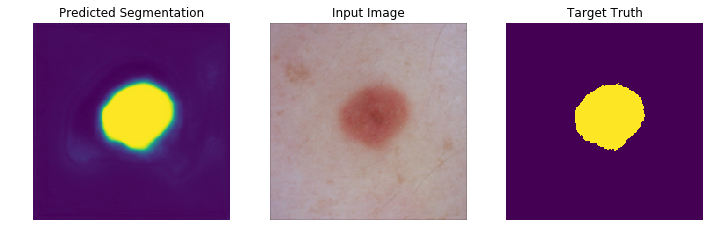

In [5]:
fig, axs = plt.subplots(1,3, figsize=(12,7))
axs[0].imshow(np.squeeze(predict_img))
axs[0].axis('off')
axs[0].set_title('Predicted Segmentation')
axs[1].imshow(np.squeeze(x_valid[20]))
axs[1].axis('off')
axs[1].set_title('Input Image')
axs[2].imshow(np.squeeze(y_valid[20]))
axs[2].axis('off')
axs[2].set_title('Target Truth')

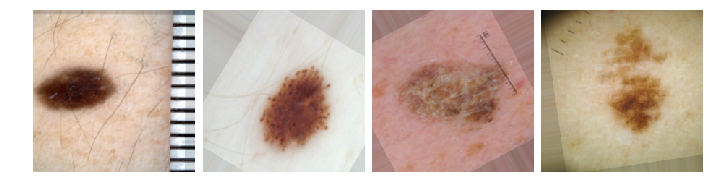

In [6]:
# Visualising some augmented images generated from generator
fig, axs = plt.subplots(1,4, figsize=(12,7))
fig.subplots_adjust(hspace=0.1, wspace=0.05)
for i in range(4):
    axs[i].imshow(np.array(image_generator[1][i+5]).astype(np.uint8))
    axs[i].axis('off')